In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [2]:
# load local model file and initialize model class
from model import ModelClass
model = ModelClass() # set a few number of periods.

par = model.par
sol = model.sol
sim = model.sim

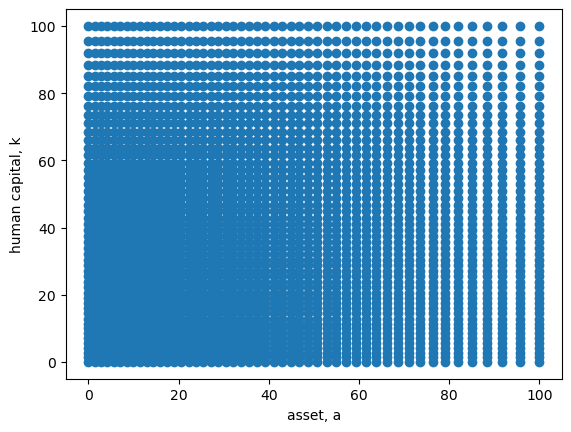

In [3]:
fig, ax = plt.subplots()
a_mesh,s_mesh = np.meshgrid(par.a_grid,par.s_grid,indexing='ij')
ax.scatter(a_mesh,s_mesh)
ax.set(xlabel='asset, a',ylabel='human capital, k');

In [4]:
%time model.solve()

We are in t = 69
We are in t = 68
We are in t = 67
We are in t = 66
We are in t = 65
We are in t = 64
We are in t = 63
We are in t = 62
We are in t = 61
We are in t = 60
We are in t = 59
We are in t = 58
We are in t = 57
We are in t = 56
We are in t = 55
We are in t = 54
We are in t = 53
We are in t = 52
We are in t = 51
We are in t = 50
We are in t = 49
We are in t = 48
We are in t = 47
We are in t = 46
We are in t = 45
We are in t = 44
We are in t = 43
We are in t = 42
We are in t = 41
We are in t = 40
We are in t = 39
We are in t = 38
We are in t = 37
We are in t = 36
We are in t = 35
We are in t = 34
We are in t = 33
We are in t = 32
We are in t = 31
We are in t = 30
We are in t = 29
We are in t = 28
We are in t = 27
We are in t = 26
We are in t = 25
We are in t = 24
We are in t = 23
We are in t = 22
We are in t = 21
We are in t = 20
We are in t = 19
We are in t = 18
We are in t = 17
We are in t = 16
We are in t = 15
We are in t = 14
We are in t = 13
We are in t = 12
We are in t = 

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
C:\Users\B465929\AppData\Local\Temp\ipykernel_12752\1931577120.py:7: SyntaxWarning: invalid escape sequence '\s'
  ax.set(xlabel='Liquid assets, $a_{T}$',ylabel='Illquid assets, $k_T$',zlabel='Consumption, $c_{T}^{\star}$');
C:\Users\B465929\AppData\Local\Temp\ipykernel_12752\1931577120.py:12: SyntaxWarning: invalid escape sequence '\s'
  ax.set(xlabel='Liquid assets, $a_{T}$',ylabel='Illquid assets, $k_T$',zlabel='Hours, $h_{T}^{\star}$');


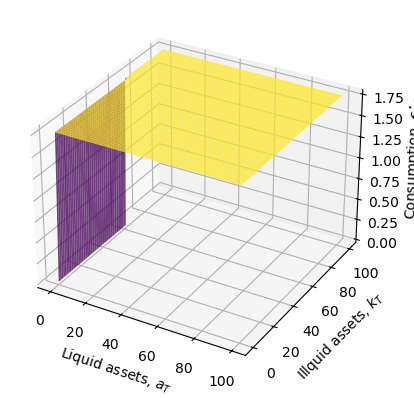

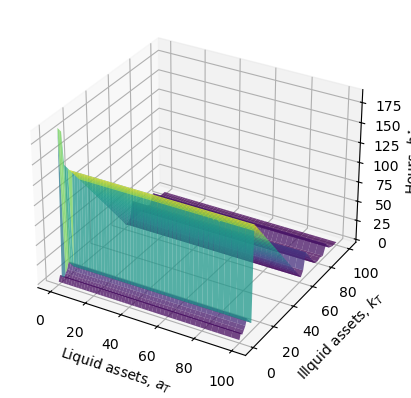

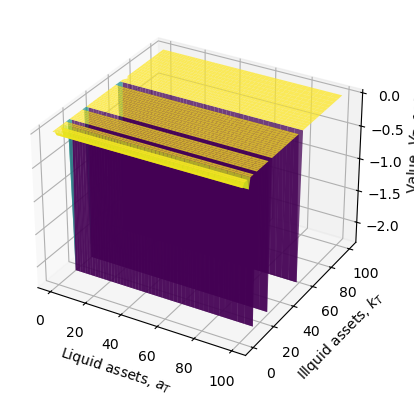

In [10]:
# last period
t = 33

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, sol.c[t],rstride=1,cstride=1,cmap='viridis', edgecolor='none',alpha=0.75);
ax.set(xlabel='Liquid assets, $a_{T}$',ylabel='Illquid assets, $k_T$',zlabel='Consumption, $c_{T}^{\star}$');

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, sol.h[t],rstride=1,cstride=1,cmap='viridis', edgecolor='none',alpha=0.75);
ax.set(xlabel='Liquid assets, $a_{T}$',ylabel='Illquid assets, $k_T$',zlabel='Hours, $h_{T}^{\star}$');

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, sol.V[t],rstride=1,cstride=1,cmap='viridis', edgecolor='none',alpha=0.75);
ax.set(xlabel='Liquid assets, $a_{T}$',ylabel='Illquid assets, $k_T$',zlabel='Value, $V_{T}$');